# Plot cellprofiler results - area, intensity, major axis and minor axis

In [1]:
import os
import glob
import sys
from pathlib import Path 
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import tifffile
import skimage.exposure as ske
import cv2
import seaborn as sns
from tqdm.notebook import tqdm, trange
import pickle
import pandas as pd

%matplotlib inline
%gui qt5

In [2]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from config import *
import cellprof as cp

In [4]:
cell_type_label = ['BM', 'BM', 'BM', 'BM', 'BM', 'BM', 'BM', 'UC', 'UC', 'UC', 'UC', 'UC', 'UC', 'UC']

In [5]:
list_pair_modif = ['DAPI', 'Nucleolin', 'ATF6', 'GOLPH4', 'TOM20']

In [6]:
# Figures location    
save_path = f"{data_figure}/morphology/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

### Heatmap of area

In [7]:
cells = cp.Cells.fromDir(data_cp)
df = cells.getFeatureDataFrame(featurematchers="AreaShape_Area").sort_index()

skipping csv file 'BM_Experiment.csv'
skipping csv file 'BM_Image.csv'
skipping csv file 'UC_Experiment.csv'
skipping csv file 'UC_Image.csv'


In [8]:
df = df.rename(columns={"BT": "BetaTubulin", "CONA": "ConcanavalinA", "G4": "GOLPH4", "NUC": "Nucleolin", "PH": "Phalloidin", "SOR": "Sortilin", "T20": "TOM20"})
df

,ATF6,BetaTubulin,ConcanavalinA,DAPI,GOLPH4,HSP60,Nucleolin,Phalloidin,Sortilin,TOM20,WGA
BM0,72077.0,110718.0,74479.0,18000.0,73537.0,106731.0,2158.0,116287.0,61584.0,88060.0,90379.0
BM1,53496.0,43207.0,58762.0,16198.0,44528.0,47291.0,1765.0,55108.0,35704.0,49251.0,50818.0
BM2,26147.0,29110.0,30292.0,10203.0,29841.0,43028.0,2572.0,36672.0,31165.0,28398.0,34451.0
BM3,92562.0,137453.0,147074.0,21401.0,86267.0,133622.0,1027.0,266663.0,88538.0,160884.0,138099.0
BM4,91513.0,118420.0,103561.0,26186.0,50304.0,92454.0,2498.0,174239.0,76510.0,173177.0,96925.0
BM5,137280.0,162026.0,167414.0,21884.0,127784.0,231791.0,887.0,229626.0,180883.0,185333.0,231986.0
BM6,79126.0,177176.0,118167.0,24240.0,89119.0,156379.0,707.0,289824.0,52895.0,137833.0,134474.0
UC0,95622.0,198615.0,119233.0,25724.0,105132.0,247370.0,10989.0,145333.0,178156.0,122737.0,130533.0
UC1,64911.0,148244.0,88994.0,23470.0,75821.0,125875.0,9814.0,71630.0,89586.0,75906.0,83281.0
UC2,64766.0,154339.0,105803.0,24846.0,69107.0,152705.0,3180.0,76489.0,70557.0,101154.0,83649.0


  0%|          | 0/1 [00:00<?, ?it/s]

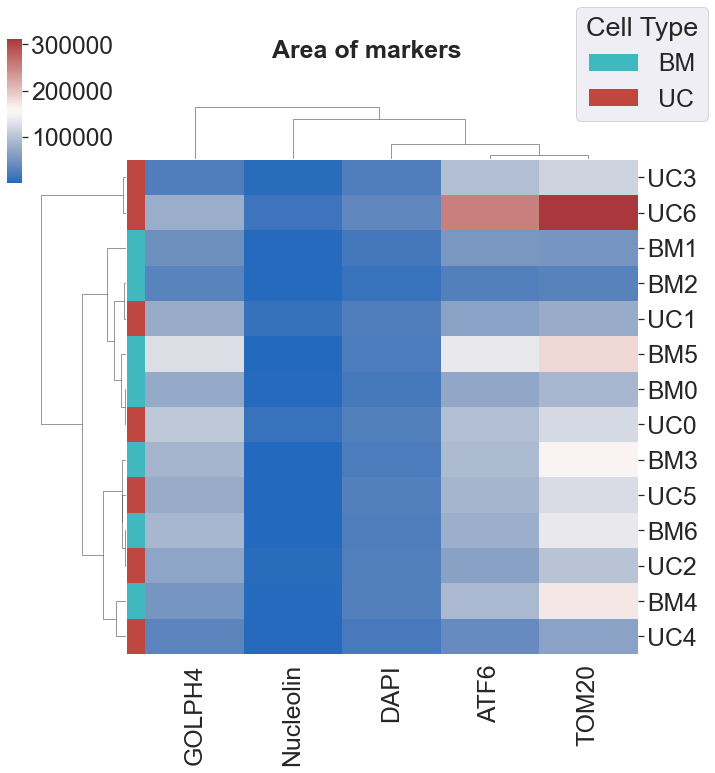

In [9]:
metric_list = [
    'correlation',
]

data_pivot = df
data_pivot = data_pivot.loc[:, list_pair_modif]

lut1 = dict(zip(set(cell_type_label), sns.hls_palette(len(set(cell_type_label)), l=0.5, s=0.5)))
row_colors1 = pd.Series(cell_type_label).map(lut1)

for metric_temp in tqdm(metric_list):
    sns.set(font_scale = 2.25)
    g=sns.clustermap(data_pivot, 
                     figsize=(10, 10),
                     row_colors=[row_colors1], 
                     yticklabels=True, 
                     cbar_pos=(0, 0.85, 0.02, .2),  
                     metric=metric_temp,
                     dendrogram_ratio=(0.15, 0.1),
                    cmap='vlag')

    for label in np.unique(np.array(cell_type_label, dtype=object)):
        g.ax_col_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(title='Cell Type', loc="upper left", bbox_to_anchor=(0.85, 3))
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 

    g.fig.suptitle(f"Area of markers", x=0.5, y=1.05, fontsize=25, fontweight='bold')
    image_path_png = save_path+"/area_clustered_"+str(metric_temp)+".png"
    g.savefig(image_path_png, bbox_inches="tight")
    plt.show()

### Heatmap of minor axis

In [10]:
cells = cp.Cells.fromDir(data_cp)
df2 = cells.getFeatureDataFrame(featurematchers="AreaShape_MinorAxisLength").sort_index()
df2 = df2.rename(columns={"BT": "BetaTubulin", "CONA": "ConcanavalinA", "G4": "GOLPH4", "NUC": "Nucleolin", "PH": "Phalloidin", "SOR": "Sortilin", "T20": "TOM20"})
df2

skipping csv file 'BM_Experiment.csv'
skipping csv file 'BM_Image.csv'
skipping csv file 'UC_Experiment.csv'
skipping csv file 'UC_Image.csv'


,ATF6,BetaTubulin,ConcanavalinA,DAPI,GOLPH4,HSP60,Nucleolin,Phalloidin,Sortilin,TOM20,WGA
BM0,176.297996,242.346131,170.616404,112.558206,176.071057,262.318577,49.680092,294.519234,168.296584,194.562232,205.619813
BM1,174.702615,152.803370,176.344430,106.953002,165.820851,164.469709,43.631131,189.621372,139.976168,167.361627,190.167951
BM2,170.489695,182.201056,180.061167,108.170436,177.396921,231.043103,54.673330,205.063640,194.533721,187.514786,203.318405
BM3,346.837486,408.635282,408.637079,136.300336,350.528813,358.460415,31.323968,483.985284,253.563308,449.219374,477.818495
BM4,365.069459,429.667497,364.213745,162.941011,206.804460,413.567643,49.682121,529.586711,286.926242,571.292445,343.913874
BM5,364.793135,383.020509,376.873232,141.532396,368.232533,415.926515,31.359264,450.019109,416.203830,418.180750,427.618486
BM6,204.441036,278.017519,247.689410,134.992503,213.946835,267.936789,22.385382,392.947657,183.643132,249.732659,338.989048
UC0,185.816722,265.052263,213.638805,137.029465,232.775647,276.839056,88.478175,222.838389,262.864750,196.722738,212.294265
UC1,212.521584,266.066213,230.106210,137.159460,221.798771,254.911174,101.556287,215.169645,245.298605,226.270843,232.729494
UC2,214.956439,290.353728,239.231574,141.486285,172.718830,293.332206,76.106545,211.208748,250.895709,224.922357,240.425211


  0%|          | 0/1 [00:00<?, ?it/s]

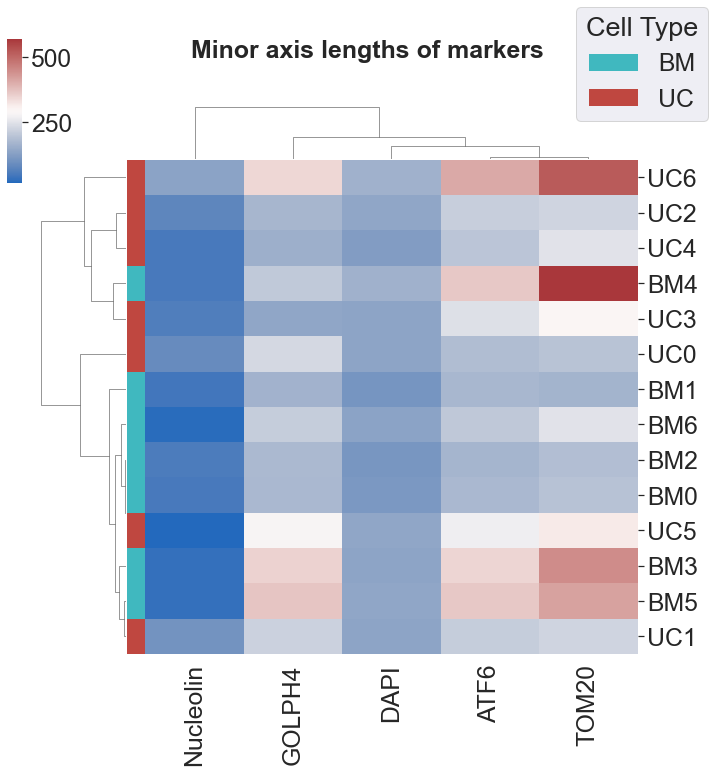

In [11]:
metric_list = [
    'correlation',
]

data_pivot = df2
data_pivot = data_pivot.loc[:, list_pair_modif]

lut1 = dict(zip(set(cell_type_label), sns.hls_palette(len(set(cell_type_label)), l=0.5, s=0.5)))
row_colors1 = pd.Series(cell_type_label).map(lut1)

for metric_temp in tqdm(metric_list):
    sns.set(font_scale = 2.25)
    g=sns.clustermap(data_pivot, 
                     figsize=(10, 10),
                     row_colors=[row_colors1], 
                     yticklabels=True, 
                     cbar_pos=(0, 0.85, 0.02, .2),  
                     metric=metric_temp,
                     dendrogram_ratio=(0.15, 0.1),
                    cmap='vlag')

    for label in np.unique(np.array(cell_type_label, dtype=object)):
        g.ax_col_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(title='Cell Type', loc="upper left", bbox_to_anchor=(0.85, 3))
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 

    g.fig.suptitle(f"Minor axis lengths of markers", x=0.5, y=1.05, fontsize=25, fontweight='bold')
    image_path_png = save_path+"/minor_axis_clustered_"+str(metric_temp)+".png"
    g.savefig(image_path_png, bbox_inches="tight")
    plt.show()

### Heatmap of major axis

In [12]:
cells = cp.Cells.fromDir(data_cp)
df3 = cells.getFeatureDataFrame(featurematchers="AreaShape_MajorAxisLength").sort_index()
df3 = df3.rename(columns={"BT": "BetaTubulin", "CONA": "ConcanavalinA", "G4": "GOLPH4", "NUC": "Nucleolin", "PH": "Phalloidin", "SOR": "Sortilin", "T20": "TOM20"})
df3

skipping csv file 'BM_Experiment.csv'
skipping csv file 'BM_Image.csv'
skipping csv file 'UC_Experiment.csv'
skipping csv file 'UC_Image.csv'


,ATF6,BetaTubulin,ConcanavalinA,DAPI,GOLPH4,HSP60,Nucleolin,Phalloidin,Sortilin,TOM20,WGA
BM0,636.765460,786.365018,640.944890,208.987960,622.367933,770.533294,62.278344,778.681968,597.713649,684.360466,636.042676
BM1,468.725847,439.982856,506.473750,195.661793,419.111478,413.768492,54.538642,466.739903,365.053523,426.752664,372.983560
BM2,204.998808,211.327038,223.278330,121.244202,223.932373,268.356565,82.918703,246.710868,210.772380,201.951252,223.656584
BM3,561.160182,730.361380,761.488781,200.281450,517.104048,595.572531,45.920981,930.703008,557.171413,699.615231,592.626591
BM4,452.470935,584.370815,528.198999,204.995628,396.704931,522.405135,84.069888,648.229071,423.538598,720.062552,494.121251
BM5,615.572579,814.977056,820.954754,197.937579,657.577717,1021.358253,38.137174,1033.739597,888.562427,777.219930,987.441143
BM6,541.135701,978.948908,720.299098,229.064981,597.289289,905.551862,74.498290,1100.639470,445.486111,882.112154,626.131632
UC0,706.871634,1250.359322,788.996826,239.541978,725.687449,1671.145267,167.382289,949.258796,990.554406,858.918854,870.179057
UC1,411.924128,838.917873,526.441181,218.476548,499.676368,854.777346,154.584817,451.442004,505.190225,482.375643,483.497188
UC2,421.994210,809.903496,588.508857,224.920858,590.885594,775.682550,96.803088,498.972949,397.589438,649.787916,483.858310


  0%|          | 0/1 [00:00<?, ?it/s]

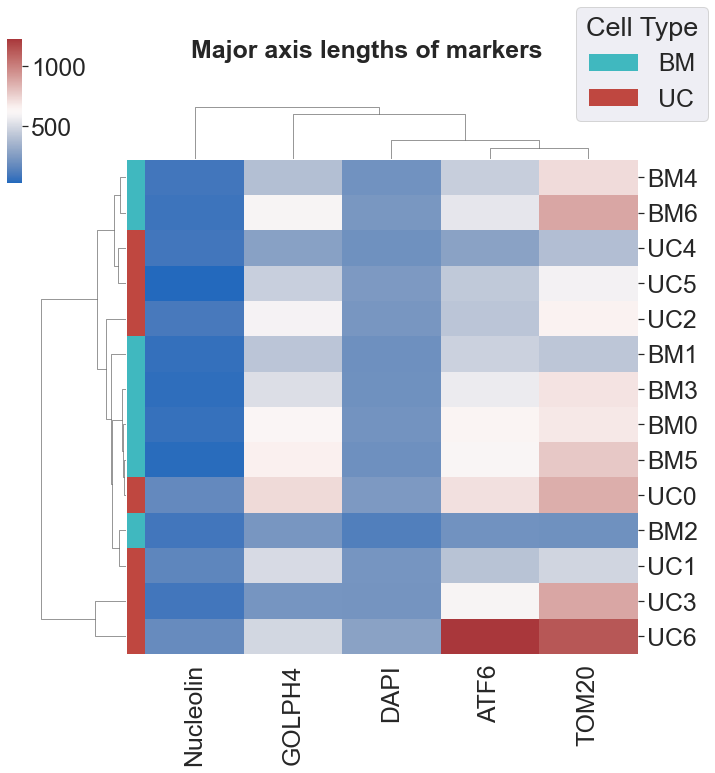

In [13]:
metric_list = [
    'correlation',
]

data_pivot = df3
data_pivot = data_pivot.loc[:, list_pair_modif]

lut1 = dict(zip(set(cell_type_label), sns.hls_palette(len(set(cell_type_label)), l=0.5, s=0.5)))
row_colors1 = pd.Series(cell_type_label).map(lut1)

for metric_temp in tqdm(metric_list):
    sns.set(font_scale = 2.25)
    g=sns.clustermap(data_pivot, 
                     figsize=(10, 10),
                     row_colors=[row_colors1], 
                     yticklabels=True, 
                     cbar_pos=(0, 0.85, 0.02, .2),  
                     metric=metric_temp,
                     dendrogram_ratio=(0.15, 0.1),
                    cmap='vlag')

    for label in np.unique(np.array(cell_type_label, dtype=object)):
        g.ax_col_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(title='Cell Type', loc="upper left", bbox_to_anchor=(0.85, 3))
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 


    g.fig.suptitle(f"Major axis lengths of markers", x=0.5, y=1.05, fontsize=25, fontweight='bold')
    image_path_png = save_path+"/major_axis_clustered_"+str(metric_temp)+".png"
    g.savefig(image_path_png, bbox_inches="tight")
    plt.show()